In [1]:
COLAB_MODE = False
SETUP_RUNTIME = False
# google colab shenanigans
if COLAB_MODE:
    if SETUP_RUNTIME:
        from google.colab import drive
        drive.mount('/content/drive')
        !pip install torch == 1.11.0 # TODO: make a requirements.txt
        !mkdir /content/data
        !gdown 1-5W-S5e7CKsJ9uY9uVXIyxgbcZZNYBrp
        !mv old-tsp-data.tar.gz /content/data/
        !tar -xzvf data/old-tsp-data.tar.gz -C /content/data/

        !git clone https://github.com/whong92/deep-ls.git
        %cd deep-ls
        !git checkout multi-sample-episodes
    else:
        %cd deep-ls

    data_root = '/content/data/tsp-data/'
    model_root = '/content/drive/MyDrive/colab_data/deep-ls/'
else:
    data_root = '../graph-convnet-tsp/data/'
    model_root = '.'

In [2]:
import cv2
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

from deepls.TSP2OptEnv import TSP2OptEnv, TSP2OptMultiEnv

font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [3]:
from deepls.agent import GRCNCriticBaselineAgent, AverageStateRewardBaselineAgent
from torch import nn
import torch
from tqdm.notebook import tqdm

In [4]:
env = TSP2OptMultiEnv(
    max_num_steps=10, 
    num_nodes=10, 
    data_f=f'{data_root}/tsp10_train_concorde.txt', 
    num_samples_per_batch=12,
    same_instance_per_batch=True,
    shuffle_data=True, 
    ret_log_tour_len=False
)
env.reset()

In [5]:
env_val = TSP2OptMultiEnv(
    max_num_steps=10, 
    num_nodes=10, 
    data_f=f'{data_root}/tsp10_test_concorde.txt',
    num_samples_per_batch=10,
    same_instance_per_batch=False,
    shuffle_data=True, 
    ret_log_tour_len=False
)
env_val.reset()

In [6]:
agent_config = {
    'replay_buffer_size': 3,
    'batch_sz': 64,
    'minibatch_sz': 32,
    'policy_optimize_every': 1,
    'critic_optimize_every': 1,
    'model': {   
        "voc_edges_in": 3,
        "hidden_dim": 128,
        "num_layers": 15,
        "mlp_layers": 3,
        "aggregation": "mean",
        "node_dim": 2,
        'dont_optimize_policy_steps': 0,
        'value_net_type': 'normal'
    },
    'optim': {
        'step_size': 1e-5, 
        'step_size_critic': 2e-4,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'device': 'cuda'
}

val_every = 1000
val_episodes = 10
start_episode = 0
train_episodes = 10000

In [7]:
def val_agent(env, agent, num_episode=200):
    avg_opt_gaps = []
    env.init()
    
    # evaluation mode
    agent.set_eval()
    for episode in tqdm(range(num_episode), leave=False):
        env.reset()
        states = env.get_state()
        actions = agent.agent_start(states)
        while True:
            # Take a random action
            rets = env.step(actions)
            states = [ret[0] for ret in rets]
            rewards = [ret[1] for ret in rets]
            dones = [ret[2] for ret in rets]

            if dones[0] == True:
                agent.agent_end(rewards)
                avg_opt_gaps.append(
                    np.mean([(state[1].tour_len / state[0].opt_tour_len) - 1. for state in states])
                )
                break
            else:
                actions = agent.agent_step(rewards, states)
    agent.set_train()
    return np.mean(avg_opt_gaps)

In [8]:
def moving_average(arr, c=100):
    return np.convolve(arr, np.ones(shape=(100,))/100., mode='valid')

In [9]:
agent = AverageStateRewardBaselineAgent() # GRCNCriticBaselineAgent()
agent.agent_init(agent_config)

In [10]:
# ckpt = torch.load(f'{model_root}/100-nodes-avg-rwd/model-15-layer-RGCN-100-nodes-07999-val-0.104.ckpt', map_location=agent.device)
# agent.net.load_state_dict(ckpt['net'])
# agent.optimizer.load_state_dict(ckpt['optimizer'])

In [ ]:
avg_rewards = []
avg_starts = []
avg_opts = []
ve_error = []
avg_train_opt_gaps = []
val_opt_gaps = []

agent.set_train()
pbar = tqdm(range(start_episode, start_episode + train_episodes))
for episode in pbar:
    env.reset()
    states = env.get_state()
    actions = agent.agent_start(states)
    avg_starts.append(np.mean([state[0].tour_len for state in states]))
    while True:
        # Take a random action
        rets = env.step(actions)
        states = [ret[0] for ret in rets]
        rewards = [ret[1] for ret in rets]
        dones = [ret[2] for ret in rets]

        if dones[0] == True:
            agent.agent_end(rewards)
            avg_rewards.append(np.mean([state[1].tour_len for state in states]))
            if agent.critic_abs_err is not None:
                ve_error.append(torch.mean(agent.critic_abs_err))
            else:
                ve_error.append(None)
            avg_opts.append(np.mean([state[0].opt_tour_len for state in states]))
            avg_train_opt_gaps.append(
                np.mean([(state[1].tour_len / state[0].opt_tour_len) - 1. for state in states])
            )
            break
        else:
            actions = agent.agent_step(rewards, states)
    
    if (episode + 1) % val_every == 0 and episode > 0:
        val_opt_gap = val_agent(env_val, agent, val_episodes)
        val_opt_gaps.append(val_opt_gap)
        # agent.save(f'{model_root}/model-15-layer-RGCN-20-nodes-{episode:05d}-val-{val_opt_gap:.3f}.ckpt')
        agent.save(f'{model_root}/20-nodes-avg-reward-from-scratch/model-15-layer-RGCN-20-nodes-{episode:05d}-val-{np.mean(avg_train_opt_gaps[-val_every:]):.3f}.ckpt')
    
    desc = f"train opt gap = {np.mean(avg_train_opt_gaps[-val_every:]):.3f}  ve_err = {np.mean(ve_error[-val_every:]):.3f}"
    if len(val_opt_gaps) > 0:
        desc += f" val opt gap = {val_opt_gaps[-1]:.3f}"
    
    pbar.set_description(desc)

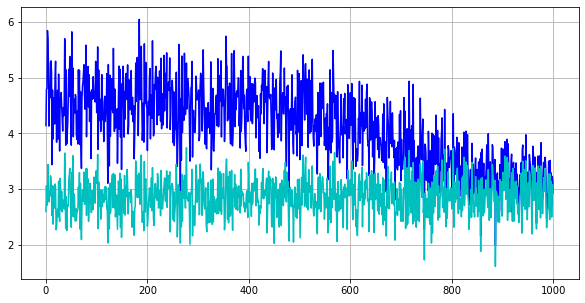

In [12]:
plt.figure(figsize=(10, 5))
# plt.plot(np.array(avg_starts), color='g')
plt.plot(np.array(avg_rewards), color='b')
plt.plot(np.array(avg_opts), 'c')
plt.grid()

In [17]:
ma_opt_gap = moving_average(np.array(avg_train_opt_gaps))

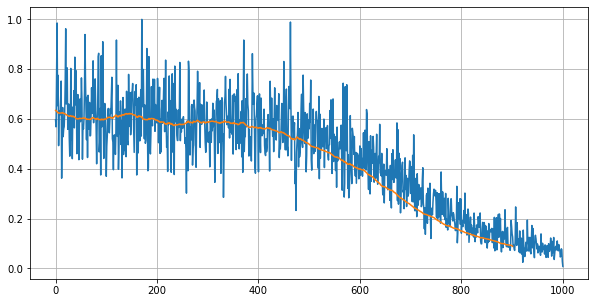

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(avg_train_opt_gaps)
plt.plot(ma_opt_gap)
plt.plot(np.arange(len(val_opt_gaps)) * val_every + 1, val_opt_gaps)
plt.grid()

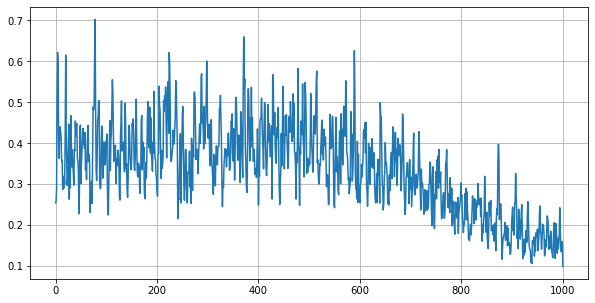

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(ve_error)
plt.grid()